In [32]:
import os
import sys
import pandas as pd 
import pingouin as pg 

import torch
import fasttext

parent_dir = os.path.dirname(os.getcwd())
src_dir = os.path.join(parent_dir, 'src')
model_dir = os.path.join(parent_dir, 'models')
class_dir = os.path.join(parent_dir,'results/classification')
sys.path.insert(0, src_dir)
import read
#import similarity_score
import embeddings


In [3]:
import clip

In [56]:
from PIL import Image
from tqdm import tqdm_notebook
import torch
from torch.nn import Softmax
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [58]:
def load_image(path):
    try:
        return Image.open(path)
    except Exception as e:
        raise RuntimeError(f"Error loading image {path}: {e}")

def compute_probabilities(model, extractor, img):
    inputs = extractor(img, return_tensors = 'pt')
    softmax = Softmax(dim=1)
    with torch.no_grad():
        logits = model(**inputs).logits
        prob_scores = softmax(logits)[0]
    return prob_scores

path = 'C:/Users/670302093/OneDrive - Signify/ClipSoundSymbolism/dataset/images/SD_face/adelaide/adelaide_0.jpeg'

img = load_image(path)

extractor = AutoImageProcessor.from_pretrained("nateraw/vit-age-classifier")
model = AutoModelForImageClassification.from_pretrained("nateraw/vit-age-classifier")


prob_scores = compute_probabilities(model, extractor, img)
young_prob, old_prob = prob_scores[0:4].sum().item(), prob_scores[4:].sum().item()

In [65]:
prob_scores

tensor([0.0005, 0.0101, 0.0541, 0.4861, 0.3469, 0.0671, 0.0222, 0.0105, 0.0026])

0.5508

In [66]:
young_prob

0.55077064037323

# tokenize dataset

In [4]:
df_characters = pd.read_csv(os.path.join(parent_dir, 'dataset/texts/avgRatings_annotated.csv'))
names = df_characters.name.unique().tolist()

In [5]:
import json

# Open the file and read its content
with open('vocab.json', 'r', encoding='utf-8') as f:
    content = f.read()

# Parse the JSON content
vocab = json.loads(content)

# Create a reverse mapping from token ID to word/subword
id_to_word = {id: word for word, id in vocab.items()}




In [13]:
tokenize_names = {}
for name in names:
    tensor = clip.tokenize(name)
    token_ids = tensor[0].tolist()

    # Map token IDs to words/subwords
    words = [id_to_word[id] for id in token_ids if id != 0 and id != 49406 and id != 49407] 

    length = len(words)

    tokenize_names[name] = {'Tokens': words, 'Length': length}

# Transform the dictionary into a DataFrame
df = pd.DataFrame(list(tokenize_names.items()), columns=['name', 'Data'])

# Create separate columns for Tokens and Length
df[['tokens', 'len_token']] = pd.DataFrame(df['Data'].tolist(), index=df.index)

# Drop the Data column
df = df.drop(columns=['Data'])


In [14]:
df_characters_subset = df_characters[['name', 'type']].drop_duplicates()

In [15]:
df_characters_subset

,name,type
0,Adelaide,real
2,Adelina,real
4,Alasdair,real
6,Alastor,madeup
8,Alecto,madeup
...,...,...
351,Wren,talking
353,Yak,talking
355,Yozadah,madeup
357,Zahara,madeup


In [16]:
df_tokenize = df.merge(df_characters_subset, on='name')

In [ ]:
df_tokenize[(df_tokenize['length'] == 1) & (df_tokenize['type'] == 'madeup')]

In [269]:
df_tokenize.to_csv('characters_tokenize.csv', index=False)

In [17]:
df_tokenize['len_name'] = df_tokenize['name'].apply(lambda x: len(x))

In [18]:
df_tokenize

,name,tokens,len_token,type,len_name
0,Adelaide,[adelaide</w>],1,real,8
1,Adelina,"[adel, ina</w>]",2,real,7
2,Alasdair,"[alas, dair</w>]",2,real,8
3,Alastor,"[al, astor</w>]",2,madeup,7
4,Alecto,"[alec, to</w>]",2,madeup,6
...,...,...,...,...,...
174,Wren,[wren</w>],1,talking,4
175,Yak,[yak</w>],1,talking,3
176,Yozadah,"[yo, zad, ah</w>]",3,madeup,7
177,Zahara,"[za, hara</w>]",2,madeup,6


In [23]:
import pandas as pd

# Calculate the mean and standard deviation
mean_length = df_tokenize.groupby('type')['len_token'].mean()
std_length = df_tokenize.groupby('type')['len_token'].std()

mean_len_name = df_tokenize.groupby('type')['len_name'].mean()
std_len_name = df_tokenize.groupby('type')['len_name'].std()

# Create a new DataFrame
df = pd.DataFrame({
    'mean_token': mean_length,
    'std_token': std_length,
    'mean_len_name': mean_len_name,
    'std_len_name': std_len_name
})

df =df.round(2)


In [22]:
df.to_csv('df_tokenize_mean_std.csv')

# merging datasets

In [116]:
def merging_dataset(df_sd, df_vq, character_df, attribute):
    
    df_sd['img_generator'] = 'sd'
    df_vq['img_generator'] = 'vqgan'

    concat_predictions = pd.concat([df_sd, df_vq], ignore_index=True)

    df_attribute = character_df.loc[character_df['attribute'] == 'age', ['name', 'type']].drop_duplicates().reset_index(drop=True)
    df_attribute['name'] = df_attribute['name'].str.lower()

    final_merge = pd.merge(concat_predictions, df_attribute, on='name', how='left')

    final_merge['attribute'] = attribute

    return final_merge
    
        
    

In [117]:
age_sd = pd.read_csv(os.path.join(class_dir,'age_predictions_SD_face.csv'))
age_vq = pd.read_csv(os.path.join(class_dir,'age_predictions_vqgan_face.csv'))
gender_sd = pd.read_csv(os.path.join(class_dir,'gender_predictions_SD_face.csv'))
gender_vq = pd.read_csv(os.path.join(class_dir,'gender_predictions_vqgan_face.csv'))

dataset_dir = os.path.join(parent_dir, 'dataset/texts')
main_df = pd.read_csv(os.path.join(dataset_dir, 'avgRatings_annotated.csv'))

In [118]:
gender_prediction = merging_dataset(gender_sd, gender_vq, main_df, 'gender')
age_prediction = merging_dataset(age_sd, age_vq, main_df, 'age')

In [123]:
age_prediction

,classifier,name,image_idx,young_prob,old_prob,img_generator,type,attribute
0,cranage,adelaide,0,0.712480,0.287520,sd,real,age
1,cranage,adelaide,1,0.480687,0.519313,sd,real,age
2,cranage,adelaide,2,0.826336,0.173664,sd,real,age
3,cranage,adelaide,3,0.719815,0.280184,sd,real,age
4,cranage,adelaide,4,0.818460,0.181541,sd,real,age
...,...,...,...,...,...,...,...,...
14275,ibombSwin,zubaida,15,0.193834,0.806166,vqgan,madeup,age
14276,ibombSwin,zubaida,16,0.015909,0.984091,vqgan,madeup,age
14277,ibombSwin,zubaida,17,0.113575,0.886424,vqgan,madeup,age
14278,ibombSwin,zubaida,18,0.050676,0.949324,vqgan,madeup,age


In [121]:
gender_prediction.to_csv('gender_predictions_merge.csv', index=False)
age_prediction.to_csv('age_predictions_merge.csv', index=False)

In [128]:
def get_subset(attribute):

    '''get subset of characters_df scored on specific attribute (gender or age)'''
    
    dataset_dir = os.path.join(parent_dir, 'dataset/texts')
    df = pd.read_csv(os.path.join(dataset_dir, 'avgRatings_annotated.csv'))
    df_attribute = df.loc[df['attribute'] == attribute, ['name', 'rating.mean', 'type']].drop_duplicates()
    df_attribute['name'] = df_attribute['name'].str.lower()
    df_attribute = df_attribute.reset_index(drop=True)
    return df_attribute

In [129]:
get_subset('gender')

,name,rating.mean,type
0,adelaide,45.727273,real
1,adelina,47.771429,real
2,alasdair,-35.657143,real
3,alastor,-38.833333,madeup
4,alecto,-35.722222,madeup
...,...,...,...
174,wren,8.200000,talking
175,yak,-37.722222,talking
176,yozadah,-15.500000,madeup
177,zahara,41.675676,madeup


# Grid Images

In [ ]:
import os
import random
import matplotlib.pyplot as plt
images_dir = os.path.join(parent_dir, 'dataset/images')
# set the path to the directory containing the images
path_sd = os.path.join(images_dir, 'SD_face')
path_vq = os.path.join(images_dir, 'vqgan_face')

# set the names and number of images per name
names = ['john', 'gmork', 'blackberry']
num_images_per_name = 1

# create a figure with a grid of subplots
num_cols = num_images_per_name
num_rows = len(names)
fig_width = 6
fig_height = num_rows * fig_width / num_cols
fig, axs = plt.subplots(num_rows, num_cols+1, figsize=(fig_width, fig_height),
                        gridspec_kw={'width_ratios': [1] * (num_cols+1),
                                     'height_ratios': [1] * num_rows})

# loop over the names and plot the images
for i, n in enumerate(names):
    # get a list of all images for this name
    dir_path = os.path.join(path, n, 'a face')
    image_files = os.listdir(dir_path)

    # randomly select num_images_per_name images
    selected_images = random.sample(image_files, num_images_per_name)

    # plot the name of the character on the left
    axs[i, 0].text(0.5, 0.5, n, fontsize=12, ha='center', va='center', fontweight='bold')
    axs[i, 0].axis('off')

    # loop over the selected images and plot them in the row
    for j, image_name in enumerate(selected_images):
        file_path = os.path.join(dir_path, image_name)
        img = plt.imread(file_path)
        axs[i, j+1].imshow(img)
        axs[i, j+1].axis('off')

# add a frame around the figure
for ax in axs.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# save the figure as a png file without background
fig.patch.set_facecolor('none')
plt.savefig('character_talking.png', bbox_inches='tight', pad_inches=0, facecolor='none')

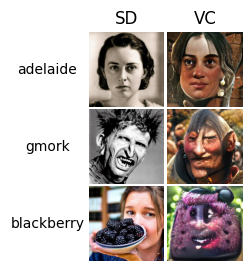

In [100]:
import os
import matplotlib.pyplot as plt

images_dir = os.path.join(parent_dir, 'dataset/images')
# set the paths to the directories containing the images
paths = [os.path.join(images_dir, 'SD_face'), os.path.join(images_dir, 'vqgan_face')]

# set the names and the corresponding images you want to display
names_images = {
    'adelaide': ['adelaide_2.jpeg', 'adelaide_12.jpeg'],
    'gmork': ['gmork_4.jpeg', 'gmork_7.jpeg'],
    'blackberry': ['blackberry_19.jpeg', 'blackberry_9.jpeg']
}

# create a figure with a grid of subplots
num_cols = len(paths)
num_rows = len(names_images)
fig_width = 3
fig_height = 3#num_rows * fig_width / num_cols
fig, axs = plt.subplots(num_rows, num_cols+1, figsize=(fig_width, fig_height),
                        gridspec_kw={'width_ratios': [1] * (num_cols+1),
                                     'height_ratios': [1] * num_rows})

# Add labels on top of the columns
axs[0, 1].set_title('SD')
axs[0, 2].set_title('VC')

# loop over the names and plot the images
for i, (n, images) in enumerate(names_images.items()):
    # plot the name of the character on the left
    axs[i, 0].text(0.5, 0.5, n, fontsize=10, ha='center', va='center')
    axs[i, 0].axis('off')

    # loop over the paths and get the selected image for this name
    for p, path in enumerate(paths):
        # get the selected image
        image_name = images[p]
        file_path = os.path.join(path, n, image_name)
        img = plt.imread(file_path)
        axs[i, p+1].imshow(img)
        axs[i, p+1].axis('off')

# add a frame around the figure
for ax in axs.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# save the figure as a png file without background
fig.patch.set_facecolor('none')
plt.savefig('character_talking.png', bbox_inches='tight', pad_inches=0, facecolor='none')


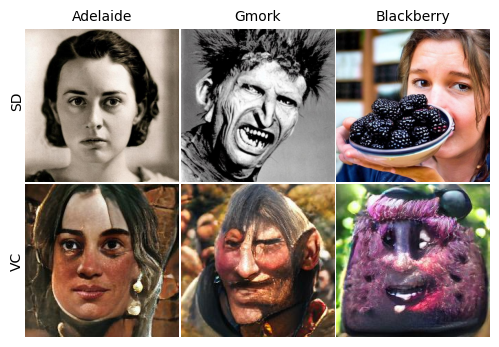

In [185]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# set the paths to the directories containing the images
paths = [os.path.join(images_dir, 'SD_face'), os.path.join(images_dir, 'vqgan_face')]

# set the names and the corresponding images you want to display
names_images = {
    'adelaide': ['adelaide_2.jpeg', 'adelaide_12.jpeg'],
    'gmork': ['gmork_4.jpeg', 'gmork_7.jpeg'],
    'blackberry': ['blackberry_19.jpeg', 'blackberry_9.jpeg']
}

# create a new figure with larger size
fig, axs = plt.subplots(2, 3, figsize=(6, 4))

# loop over each name and its corresponding images
for i, (name, images) in enumerate(names_images.items()):
    # loop over each image
    for j, image in enumerate(images):
        # read the image
        img = mpimg.imread(os.path.join(paths[j], name, image))
        # display the image
        axs[j, i].imshow(img)
        axs[j, i].axis('off')  # to hide the axis

    # set the title for the column
    axs[0, i].set_title(name.capitalize(), fontsize=10)

# add row titles to the figure directly
fig.text(0.10, 0.7, 'SD', va='center', rotation='vertical', fontsize=10)
fig.text(0.10, 0.3, 'VC', va='center', rotation='vertical', fontsize=10)

# adjust the subplot parameters for better display
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# display the plot
plt.savefig('character_talking.png', bbox_inches='tight', pad_inches=0, facecolor=None)

